In [51]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [52]:
normalized_data = pd.read_csv("normalized_stock_data.csv")

print(f"there are {len(normalized_data)} rows")
normalized_data.head()

there are 262 rows


,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,0.002198,0.000487,0.006397,0.001871,0.000000,0.4,0.0
1,0.001843,0.000000,0.003596,0.001100,0.269540,0.0,0.0
2,0.000939,0.002022,0.005530,0.003165,0.277210,0.0,0.0
3,0.003480,0.003948,0.008077,0.005852,0.386136,0.0,0.0
4,0.006016,0.004188,0.010104,0.005416,0.132201,0.0,0.0


In [53]:
# create segmented sequences
def create_sequence(data, seq_len):
    sequences = []
    for i in range(len(data) - seq_len):
        sequences.append(data[i : i + seq_len])
    return np.array(sequences)

sequence_length = 3
sequences = create_sequence(normalized_data, sequence_length)
# [[row1, row2, row3], .... []]

print(len(sequences))

259


In [54]:
# train-test split (70-30 split)
split_ratio = 0.7
train_size = int(len(sequences) * split_ratio)

print(f"train size: {train_size}")
print(f"test size: {len(sequences) - train_size}")

train_sequences = sequences[:train_size]
test_sequences = sequences[train_size:]

print(f"train sequences: {len(train_sequences)}")
print(f"test sequences: {len(test_sequences)}")

train size: 181
test size: 78
train sequences: 181
test sequences: 78


In [55]:
# Key parameters
#seq_length = 60  # Sequence length
seq_length = 3
feature_dim = 7  # Number of features
hidden_dim = 128  # Hidden units in LSTM and RNN
batch_size = 32

In [56]:
# Generator: LSTM
class Generator(nn.Module):
    def __init__(self, feature_dim, hidden_dim, seq_length):
        super(Generator, self).__init__()
        self.lstm = nn.LSTM(feature_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, feature_dim)  # Map hidden_dim to feature_dim for each time step
        self.tanh = nn.Tanh()
        self.seq_length = seq_length

    def forward(self, x):
        hidden_state = torch.zeros(1, x.size(0), hidden_dim).to(x.device)
        cell_state = torch.zeros(1, x.size(0), hidden_dim).to(x.device)
        output, _ = self.lstm(x, (hidden_state, cell_state))
        output = self.fc(output)  # Apply fc to all time steps
        return self.tanh(output)

In [57]:
# Discriminator: RNN
class Discriminator(nn.Module):
    def __init__(self, feature_dim, hidden_dim, seq_length):
        super(Discriminator, self).__init__()
        self.rnn = nn.RNN(input_size=feature_dim, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim * seq_length, 1)  # Match input size to (hidden_dim * seq_length)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: (batch_size, seq_length, feature_dim)
        rnn_out, _ = self.rnn(x)
        flattened = rnn_out.contiguous().view(x.size(0), -1)  # Shape: (batch_size, hidden_dim * seq_length)
        output = self.fc(flattened)
        return self.sigmoid(output)

In [58]:
# Instantiate models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(feature_dim, hidden_dim, seq_length).to(device)
discriminator = Discriminator(feature_dim, hidden_dim, seq_length).to(device)

In [59]:
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.001)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.001)

Epoch [1/1000], Loss D: 1.3561, Loss G: 0.6821
Epoch [2/1000], Loss D: 1.2873, Loss G: 0.7373
Epoch [3/1000], Loss D: 1.2122, Loss G: 0.7989
Epoch [4/1000], Loss D: 1.1264, Loss G: 0.8520
Epoch [5/1000], Loss D: 1.0607, Loss G: 0.9105
Epoch [6/1000], Loss D: 1.0528, Loss G: 0.9551
Epoch [7/1000], Loss D: 1.1836, Loss G: 0.9237
Epoch [8/1000], Loss D: 1.3728, Loss G: 0.9607
Epoch [9/1000], Loss D: 1.4099, Loss G: 0.9976
Epoch [10/1000], Loss D: 1.1816, Loss G: 1.1924
Epoch [11/1000], Loss D: 0.8683, Loss G: 1.4245
Epoch [12/1000], Loss D: 0.6491, Loss G: 1.5861
Epoch [13/1000], Loss D: 0.6427, Loss G: 1.5903
Epoch [14/1000], Loss D: 0.9280, Loss G: 1.3639
Epoch [15/1000], Loss D: 1.4522, Loss G: 1.0100
Epoch [16/1000], Loss D: 1.7529, Loss G: 0.8598
Epoch [17/1000], Loss D: 1.4760, Loss G: 0.9838
Epoch [18/1000], Loss D: 0.9350, Loss G: 1.3103
Epoch [19/1000], Loss D: 0.4878, Loss G: 1.9622
Epoch [20/1000], Loss D: 0.2818, Loss G: 2.4543
Epoch [21/1000], Loss D: 0.2064, Loss G: 2.7190
E

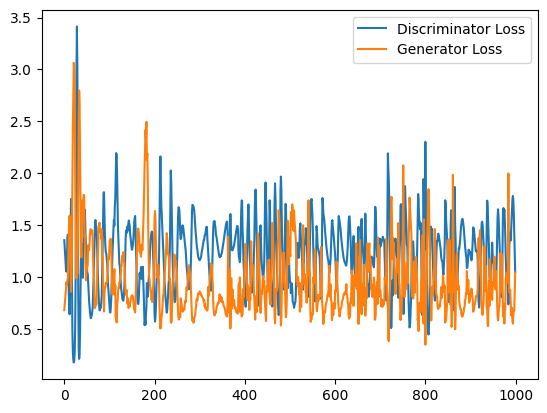

In [ ]:
# Track losses
losses_D = []
losses_G = []

def train_GAN(generator, discriminator, data, epochs=1000, batch_size=32):
    real_label = 1.0
    fake_label = 0.0

    for epoch in range(epochs):
        epoch_loss_D = 0
        epoch_loss_G = 0

        for i in range(0, len(data) - batch_size, batch_size):
            real_data = torch.tensor(data[i:i + batch_size], dtype=torch.float32).to(device)

            # Train Discriminator
            discriminator.zero_grad()
            output_real = discriminator(real_data)
            label_real = torch.full((batch_size, 1), real_label, dtype=torch.float32).to(device)
            loss_real = criterion(output_real, label_real)

            noise = torch.randn(batch_size, seq_length, feature_dim).to(device)
            fake_data = generator(noise)
            output_fake = discriminator(fake_data.detach())
            label_fake = torch.full((batch_size, 1), fake_label, dtype=torch.float32).to(device)
            loss_fake = criterion(output_fake, label_fake)

            loss_D = loss_real + loss_fake
            loss_D.backward()
            optimizer_D.step()
            epoch_loss_D += loss_D.item()

            # Train Generator
            generator.zero_grad()
            output_fake_for_G = discriminator(fake_data)
            label_gen = torch.full((batch_size, 1), real_label, dtype=torch.float32).to(device)
            loss_G = criterion(output_fake_for_G, label_gen)
            loss_G.backward()
            optimizer_G.step()
            epoch_loss_G += loss_G.item()

        losses_D.append(epoch_loss_D / (len(data) // batch_size))
        losses_G.append(epoch_loss_G / (len(data) // batch_size))
        print(f"Epoch [{epoch+1}/{epochs}], Loss D: {losses_D[-1]:.4f}, Loss G: {losses_G[-1]:.4f}")

train_GAN(generator, discriminator, train_sequences, epochs=1000, batch_size=32)
# Visualize losses
plt.plot(losses_D, label="Discriminator Loss")
plt.plot(losses_G, label="Generator Loss")
plt.legend()
plt.show()